Unsupervised representational learning using DCGAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os 
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder

In [2]:
class Discriminator(nn.Module):
    def __init__(self,channel_img,features_d):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channel_img,features_d,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d,features_d*2,4,2,1),
            self._block(features_d*2,features_d*4,4,2,1),
            self._block(features_d*4,features_d*8,4,2,1),
            self._block(features_d*8,features_d*16,4,2,1),
            nn.Conv2d(features_d*16,1,4,2,0),
            nn.Sigmoid(),
        )
            
    def _block(self,in_channels,out_channels,kernel_size,stride,padding,bias=False):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self,x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def  __init__(self,channels_noise,img_dim,features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            self._block(channels_noise,features_g*32,4,1,0),
            self._block(features_g*32,features_g*16,4,2,1),
            self._block(features_g*16,features_g*8,4,2,1),
            self._block(features_g*8,features_g*4,4,2,1),
            self._block(features_g*4,features_g*2,4,2,1),
            nn.ConvTranspose2d(features_g*2,img_dim,4,2,1),
            nn.Tanh(),
        )
    
    def _block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
#             nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        
    def forward(self,x):
        return self.gen(x)

In [4]:
# initalizing weights of the model with mean 0 and std dev 1
def initialize_weights(model):
    for m in model.modules():
#         print(m)
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02)

In [5]:
def test():
    N, in_channels, H, W = 8,3,128,128
    noise =100
    X = torch.randn((N,in_channels,H,W))
    disc = Discriminator(in_channels,8)
    initialize_weights(disc)
    assert disc(X).shape == (N,1,1,1), "Disc Failed"
    gen = Generator(noise,in_channels,8)
    z = torch.randn((N,noise,1,1))
    assert gen(z).shape == (N,in_channels,H,W), "gen Failed"
    print("success")

In [6]:
test()

success


In [7]:
def show_images(images, nmax=32):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=32):
    for images, _ in dl:
        show_images(images, nmax)
        break

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
# #hyperparameters
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# img_size = 64
# features_gen =64
# features_disc = 64
# batch_size = 128
# noise_dim = 100
# epochs=1000
# channels = 3
# lr=2e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# img_size = 128
# features_gen =128
# features_disc = 128
# batch_size = 128
# noise_dim = 150
# epochs=500
# channels = 3
# lr=2e-4

img_size = 128
features_gen = 128
features_disc = 128
batch_size = 64  # Reducing batch size to accommodate larger image size
noise_dim = 200
channels = 3

# Training configuration
epochs = 1000
lr = 3e-4

In [9]:
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size), 
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(channels)], [0.5 for _ in range(channels)]
        ),
    ]
)

In [10]:
# dataset = datasets.MNIST(
#     root="dataset/", train=True, transform=transform, download=True
# )

dataset = ImageFolder(r"./dataset/", transform=transform)

dataloader = DataLoader(dataset, batch_size, shuffle=True)
gen = Generator(noise_dim, channels, features_gen).to(device)
disc = Discriminator(channels, features_disc).to(device)
initialize_weights(gen)
initialize_weights(disc)

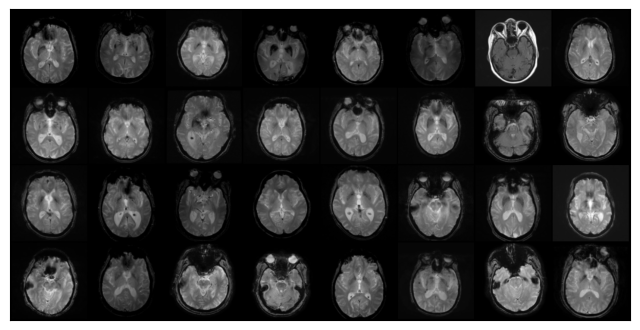

In [11]:
show_batch(dataloader)

In [12]:
opt_gen = optim.Adam(gen.parameters(), lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [13]:
# Replace 'output_directory' with your desired directory path
output_directory = 'generated_images_ADNI_128'
os.makedirs(output_directory, exist_ok=True)

In [14]:
fixed_noise = torch.randn(32, noise_dim, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0
gen.train()
disc.train()
for epoch in range(epochs):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
       # Print losses occasionally and save a grid of generated fake images
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)

                # Save a grid of generated fake images
                fake_grid = vutils.make_grid(fake, normalize=True, padding=2, nrow=8)  # Adjust nrow as needed

                image_filename = os.path.join(output_directory, f'fake_images_epoch{epoch}_batch{batch_idx}.png')
                vutils.save_image(fake_grid, image_filename)

                # Display real and fake images in TensorBoard
                img_grid_real = vutils.make_grid(real[:32], normalize=True, padding=2, nrow=8)
                img_grid_fake = vutils.make_grid(fake[:32], normalize=True, padding=2, nrow=8)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1


Epoch [0/1000] Batch 0/21                   Loss D: 0.6893, loss G: 1.1754
Epoch [1/1000] Batch 0/21                   Loss D: 0.3059, loss G: 2.4074
Epoch [2/1000] Batch 0/21                   Loss D: 1.4345, loss G: 2.1653
Epoch [3/1000] Batch 0/21                   Loss D: 0.6075, loss G: 1.4078
Epoch [4/1000] Batch 0/21                   Loss D: 0.6533, loss G: 1.2206
Epoch [5/1000] Batch 0/21                   Loss D: 0.7173, loss G: 1.1001
Epoch [6/1000] Batch 0/21                   Loss D: 0.7045, loss G: 1.2807
Epoch [7/1000] Batch 0/21                   Loss D: 0.6260, loss G: 0.6727
Epoch [8/1000] Batch 0/21                   Loss D: 0.6542, loss G: 1.8728
Epoch [9/1000] Batch 0/21                   Loss D: 0.7526, loss G: 1.9216
Epoch [10/1000] Batch 0/21                   Loss D: 0.6458, loss G: 1.8950
Epoch [11/1000] Batch 0/21                   Loss D: 0.5995, loss G: 1.1723
Epoch [12/1000] Batch 0/21                   Loss D: 0.6215, loss G: 1.4222
Epoch [13/1000] Batch 

Epoch [108/1000] Batch 0/21                   Loss D: 0.3918, loss G: 3.5801
Epoch [109/1000] Batch 0/21                   Loss D: 0.6156, loss G: 3.1204
Epoch [110/1000] Batch 0/21                   Loss D: 0.3291, loss G: 2.8373
Epoch [111/1000] Batch 0/21                   Loss D: 0.2470, loss G: 3.8590
Epoch [112/1000] Batch 0/21                   Loss D: 0.5385, loss G: 3.9738
Epoch [113/1000] Batch 0/21                   Loss D: 0.2111, loss G: 2.5842
Epoch [114/1000] Batch 0/21                   Loss D: 0.3237, loss G: 3.3640
Epoch [115/1000] Batch 0/21                   Loss D: 0.6765, loss G: 5.6621
Epoch [116/1000] Batch 0/21                   Loss D: 0.5641, loss G: 3.8116
Epoch [117/1000] Batch 0/21                   Loss D: 0.7298, loss G: 4.8569
Epoch [118/1000] Batch 0/21                   Loss D: 0.5078, loss G: 3.8686
Epoch [119/1000] Batch 0/21                   Loss D: 0.6144, loss G: 3.9760
Epoch [120/1000] Batch 0/21                   Loss D: 0.1866, loss G: 3.9140

Epoch [215/1000] Batch 0/21                   Loss D: 0.1625, loss G: 5.0782
Epoch [216/1000] Batch 0/21                   Loss D: 0.0197, loss G: 4.7901
Epoch [217/1000] Batch 0/21                   Loss D: 0.0441, loss G: 3.8787
Epoch [218/1000] Batch 0/21                   Loss D: 0.0259, loss G: 4.8438
Epoch [219/1000] Batch 0/21                   Loss D: 0.0418, loss G: 4.4845
Epoch [220/1000] Batch 0/21                   Loss D: 0.0178, loss G: 5.0873
Epoch [221/1000] Batch 0/21                   Loss D: 0.0623, loss G: 4.6093
Epoch [222/1000] Batch 0/21                   Loss D: 0.2714, loss G: 5.5464
Epoch [223/1000] Batch 0/21                   Loss D: 0.7687, loss G: 10.9711
Epoch [224/1000] Batch 0/21                   Loss D: 0.2152, loss G: 8.1584
Epoch [225/1000] Batch 0/21                   Loss D: 0.0233, loss G: 4.2759
Epoch [226/1000] Batch 0/21                   Loss D: 0.0110, loss G: 5.3703
Epoch [227/1000] Batch 0/21                   Loss D: 0.6113, loss G: 5.922

Epoch [322/1000] Batch 0/21                   Loss D: 0.0191, loss G: 5.5842
Epoch [323/1000] Batch 0/21                   Loss D: 0.0345, loss G: 6.1527
Epoch [324/1000] Batch 0/21                   Loss D: 0.0054, loss G: 6.5706
Epoch [325/1000] Batch 0/21                   Loss D: 0.0188, loss G: 5.8200
Epoch [326/1000] Batch 0/21                   Loss D: 0.0165, loss G: 5.2867
Epoch [327/1000] Batch 0/21                   Loss D: 0.7360, loss G: 20.0332
Epoch [328/1000] Batch 0/21                   Loss D: 0.4059, loss G: 12.6754
Epoch [329/1000] Batch 0/21                   Loss D: 0.4460, loss G: 5.2094
Epoch [330/1000] Batch 0/21                   Loss D: 0.0143, loss G: 5.1421
Epoch [331/1000] Batch 0/21                   Loss D: 0.0022, loss G: 12.2964
Epoch [332/1000] Batch 0/21                   Loss D: 0.0027, loss G: 6.4837
Epoch [333/1000] Batch 0/21                   Loss D: 0.0048, loss G: 6.2593
Epoch [334/1000] Batch 0/21                   Loss D: 0.0041, loss G: 6.0

KeyboardInterrupt: 

In [15]:
torch.save(disc.state_dict(), "./models/Discriminator_128.pth.tar")
torch.save(gen.state_dict(), "./models/Generator_adni_128.pth.tar")

In [ ]:
ss G: 6.5978
Epoch [342/1000] Batch 0/21                   Loss D: 0.0155, loss G: 7.5810
Epoch [343/1000] Batch 0/21                   Loss D: 0.0051, loss G: 15.9781
Epoch [344/1000] Batch 0/21                   Loss D: 0.0104, loss G: 6.8011
Epoch [345/1000] Batch 0/21                   Loss D: 0.0109, loss G: 5.4625
Epoch [346/1000] Batch 0/21                   Loss D: 0.0458, loss G: 7.1430
Epoch [347/1000] Batch 0/21                   Loss D: 0.0076, l